#### Fourier Analysis Networks

FANs leverage Fourier Analysis principles to encode periodic patterns directly within neural networks. This approach makes FANs particularly effective at modeling periodic data, outperforming MLPs, KANs, and Transformers. They excel in representing both periodic and non-periodic symbolic formulas and, when integrated into a Transformer model, surpass MLP-based Transformers, LSTMs, and Mamba in time series forecasting and language modeling. Remarkably, FANs achieve these results while using fewer parameters and floating-point operations (FLOPs) than their counterparts.

Refer: [Fourier Analysis Networks (FANs) Are Here To Break Barriers In AI](https://levelup.gitconnected.com/fourier-analysis-networks-fans-are-here-to-break-barriers-in-ai-1c521c6656bc)

#### Generating A Synthetic Dataset

Generate a dataset with samples obtained from a uniform distribution between 1 and 10 with added Gaussian noise, based on the equation below:

`y = sin⁡(2πx) + cos⁡(3πx)`

In [ ]:
import numpy as np
from torch.utils.data import Dataset

class SymbolicDataset(Dataset):
    def __init__(self, num_samples, noise_level):
        # Inputs obtained from sampling a uniform distribution
        self.x = np.random.uniform(0, 10, (num_samples, 1)).astype(np.float32)
        #Outputs calculated as per the periodic formula (shown above)
        self.y = (np.sin(2 * np.pi * self.x) + np.cos(3 * np.pi * self.x)).astype(np.float32)
        #Noise addition
        self.y += noise_level * np.random.randn(*self.y.shape).astype(np.float32)

    # Method that returns the number of samples in the dataset
    def __len__(self):
        return len(self.x)
    
    # Method that retrieves the sample at index 'idx'
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x[idx])
        y = torch.from_numpy(self.y[idx])
        return x, y

#### Defining the FAN Layer

Define a single FAN layer using the class FANLayer below, based on the following equation.

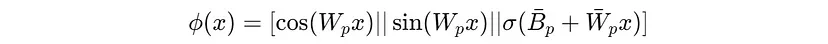

In [ ]:
import torch
import torch.nn as nn

class FANLayer(nn.Module):
    def __init__(self, in_features, d_p, d_p_bar, activation=nn.GELU()):
        super().__init__()
        self.Wp = nn.Parameter(torch.randn(in_features, d_p))
        self.Wp_bar = nn.Parameter(torch.randn(in_features, d_p_bar))
        self.Bp_bar = nn.Parameter(torch.zeros(d_p_bar))
        self.activation = activation 

    def forward(self, x):
        cos_term = torch.cos(torch.matmul(x, self.Wp))
        sin_term = torch.sin(torch.matmul(x, self.Wp))
        non_periodic_term = self.activation(torch.matmul(x, self.Wp_bar) + self.Bp_bar)
        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)

#### Defining the FAN Model

Stack multiple FAN layers to create a FAN model based on the following equations.

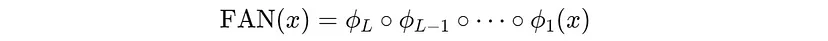

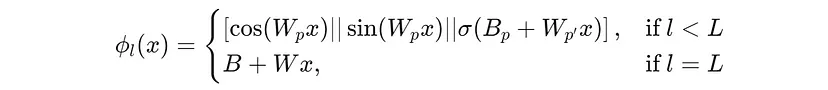

In [ ]:
class FAN(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers, activation=nn.GELU()):
        super().__init__()

        self.num_layers = num_layers 
        self.layers = nn.ModuleList()

        # d_p set to a quarter of the hidden dimension as per the original research paper
        d_p = hidden_dim // 4 
        d_p_bar = hidden_d
        
        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            self.layers.append(FANLayer(in_features, d_p, d_p_bar, activation))
            # Updated after each layer to match the output dimension of the previous layer
            in_features = 2 * d_p + d_p_bar 
        
        # Parameters for the final layer
        self.WL = nn.Parameter(torch.randn(in_features, 1))
        self.BL = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        # Implementation of the final layer
        return torch.matmul(x, self.WL) + self.BL

#### Defining the MLP Model

Define an MLP model and compare it later with the FAN. The MLP lacks the periodic components (the sine and cosine terms) present in a FAN.

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers):
        super().__init__()

        layers = []
        
        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(in_features, hidden_dim))
            layers.append(nn.GELU()) #GELU activation similar to the FAN
            in_features = hidden_dim
        
        # Implementation of the last layer
        layers.append(nn.Linear(hidden_dim, 1))

        # Constructing a Sequential neural network with the layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#### Defining the Training Loops

Define the loops to train our FAN and MLP models using the [AdamW optimizer](https://intoai.pub/p/the-new-adam-mini-optimizer-is-here).

In [ ]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

def train_model(train_dataset, val_dataset, model, epochs, batch_size, lr, model_name):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Using the MSE loss
    criterion = nn.MSELoss()

    # Using the AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * x_batch.size(0)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
                epoch_val_loss += loss.item() * x_batch.size(0)

        # Computing average losses
        epoch_train_loss /= len(train_dataset)
        epoch_val_loss /= len(val_dataset)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Printing losses every 50 epochs
        if epoch % 50 == 0 or epoch == 1 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} - {model_name} Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses

#### Defining the Evaluation Function

Define the plotting functions to evaluate the performance of the models.

In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(fan_model, mlp_model):
    # Creating test dataset sampled evenly (compare it with training data)
    x_test = torch.linspace(0, 10, 1000).reshape(-1, 1).float().to(device)
    y_test = np.sin(2 * np.pi * x_test.cpu().numpy()) + np.cos(3 * np.pi * x_test.cpu().numpy())
    
    fan_model.eval()
    mlp_model.eval()

    with torch.no_grad():
        fan_pred = fan_model(x_test).cpu().numpy()
        mlp_pred = mlp_model(x_test).cpu().numpy()

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.plot(x_test.cpu().numpy(), y_test, label="True Function", color="black", linestyle="dashed")
    plt.plot(x_test.cpu().numpy(), fan_pred, label="FAN Prediction", color="blue", alpha=0.7)
    plt.plot(x_test.cpu().numpy(), mlp_pred, label="MLP Prediction", color="red", alpha=0.7)
    
    plt.legend()

    plt.title("Comparison of FAN and MLP on Symbolic Dataset")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

#### Training the Models

Train models for 500 epochs.

In [ ]:
# Defining device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Device check
print(f"Using device: {device}")
print(f"FAN model is on device: {next(fan_model.parameters()).device}")
print(f"MLP model is on device: {next(mlp_model.parameters()).device}")

# Preparing dataset
dataset = SymbolicDataset(num_samples=1000, noise_level=0.1)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Preparing models
fan_model = FAN(in_features=1, hidden_dim=32, num_layers=3).to(device)
mlp_model = MLP(in_features=1, hidden_dim=32, num_layers=3).to(device)

# Training the FAN model
print("\nStarting training for FAN model...")
fan_train_losses, fan_val_losses = train_model(train_dataset, val_dataset, fan_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN")

# Training the MLP model
print("\nStarting training for MLP model...")
mlp_train_losses, mlp_val_losses = train_model(train_dataset, val_dataset, mlp_model, epochs=500, batch_size=32, lr=0.001, model_name="MLP")

#### Visualising the Results

In [ ]:
# Using the evaluation function to plot results
evaluate_model(fan_model, mlp_model)

`FAN` converges faster and reaches a smaller MSE loss (0.02) compared to the `MLP` (with loss of 0.97).

Train a Gated FAN using the following equation:



In [ ]:
# The Gated FAN layer
class FANLayerGated(nn.Module):
    def __init__(self, in_features, d_p, d_p_bar, activation=nn.GELU(), gated=True):
        super().__init__()
        self.Wp = nn.Parameter(torch.randn(in_features, d_p))
        self.Wp_bar = nn.Parameter(torch.randn(in_features, d_p_bar))
        self.Bp_bar = nn.Parameter(torch.zeros(d_p_bar))
        self.activation = activation
        if gated:
            self.gate = nn.Parameter(torch.randn(1))

    def forward(self, x):
        cos_term = torch.cos(torch.matmul(x, self.Wp))
        sin_term = torch.sin(torch.matmul(x, self.Wp))
        non_periodic_term = self.activation(torch.matmul(x, self.Wp_bar) + self.Bp_bar)
        
        if hasattr(self, 'gate'):
            gate = torch.sigmoid(self.gate)
            cos_term = gate * cos_term
            sin_term = gate * sin_term
            non_periodic_term = (1 - gate) * non_periodic_term

        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)

# The Gated FAN model
class FANGated(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers, activation=nn.GELU(), gated=True):
        super().__init__()
        self.layers = nn.ModuleList()
        
        d_p = hidden_dim // 4
        d_p_bar = hidden_dim

        for _ in range(num_layers - 1):
            self.layers.append(FANLayerGated(in_features, d_p, d_p_bar, activation, gated))
            in_features = 2 * d_p + d_p_bar  

        self.output_layer = nn.Linear(in_features, 1) 

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

The losses tell a better picture of where a Gated FAN exceeds the performance of a FAN and MLP.